In [22]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim,utils,torch

In [23]:
transform = transforms.Compose([transforms.ToTensor(),
                              ])

In [24]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [25]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
#images=(images+1)/2
print(images.shape)
print(torch.max(images))
print(torch.min(images))
print(labels.shape)

torch.Size([64, 1, 28, 28])
tensor(1.)
tensor(0.)
torch.Size([64])


In [26]:
class autoencoder(nn.Module):
    input_size = 784
    hidden_sizes = [256, 32]
    output_size = 16
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(self.input_size, self.hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[0], self.hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[1], self.output_size))
        self.decoder = nn.Sequential(nn.Linear(self.output_size, self.hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[1], self.hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[0], self.input_size),
                      nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
vanila_ae = autoencoder()
print(vanila_ae)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [27]:

images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = vanila_ae(images) #log probabilities

criterion = nn.MSELoss()

#tlabls = labelTransform(labels,10)
loss = criterion(logps,images) #calculate the loss


In [28]:
print('Before backward pass: \n', vanila_ae.encoder[0].weight.grad)
loss.backward()
print('After backward pass: \n', vanila_ae.encoder[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


Epoch 0 - Training loss: 0.03503860723473497
Epoch 1 - Training loss: 0.02472064897084414
Epoch 2 - Training loss: 0.022933481777432378
Epoch 3 - Training loss: 0.022364772699360273
Epoch 4 - Training loss: 0.022139111944813845
Epoch 5 - Training loss: 0.02205507005098214
Epoch 6 - Training loss: 0.021944952205315962
Epoch 7 - Training loss: 0.021925703610486187
Epoch 8 - Training loss: 0.0218169838070933
Epoch 9 - Training loss: 0.021858897534753088

Training Time (in minutes) = 4.162764497598013


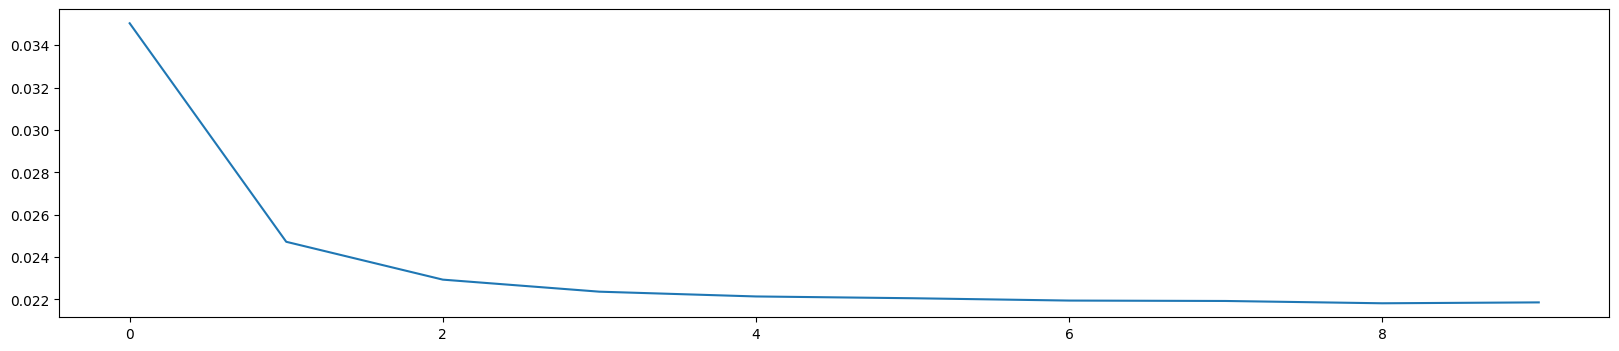

In [29]:
optimizer = optim.Adam(vanila_ae.parameters(), lr=0.01, weight_decay=1e-5)
time0 = time()
epochs = 10
loss_hist = []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        
        output = vanila_ae(images)
        loss = criterion(output, images)
        
        #This is where the model learns by backpropagating
        optimizer.zero_grad()
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        loss_hist.append(running_loss/len(trainloader))
print("\nTraining Time (in minutes) =",(time()-time0)/60)
plt.figure(figsize=(20, 4))
plt.plot(loss_hist)
plt.show()

In [30]:
# To measure embeddings accuracy
# Using SVM to predict labels from embedings
train_images = torch.tensor([])
train_encoded = torch.tensor([])
train_labels = torch.tensor([])

for imgs, lbls in trainloader:
        imgs = imgs.view(imgs.shape[0], -1)
        en = vanila_ae.encoder(imgs)
        train_encoded=torch.cat((train_encoded,en))
        train_labels=torch.cat((train_labels,lbls))
        train_images=torch.cat((train_images,imgs))

print(train_encoded.shape)
print(train_labels.shape)
from sklearn.svm import SVC
clf =  SVC(gamma='auto')

with torch.no_grad():  
        clf.fit(train_encoded,train_labels)

torch.Size([60000, 16])
torch.Size([60000])


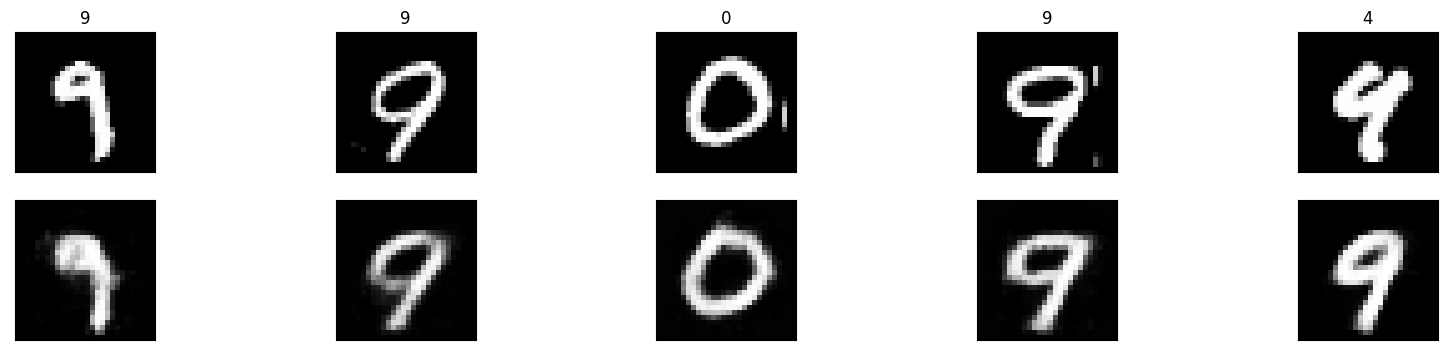

In [38]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    encoded = vanila_ae.encoder(images.view(-1, 784))
    decoded = vanila_ae.decoder(encoded)

plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(labels[i].numpy())
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(decoded[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [32]:
#preparing test embeddings

test_encoded = torch.tensor([])
test_labels = torch.tensor([])
test_images = torch.tensor([])

for imgs, lbls in valloader:
        imgs = imgs.view(imgs.shape[0], -1)
        en = vanila_ae.encoder(imgs)
        test_encoded=torch.cat((test_encoded,en))
        test_labels=torch.cat((test_labels,lbls))
        test_images=torch.cat((test_images,imgs))

print(test_encoded.shape)
print(test_labels.shape)

torch.Size([10000, 16])
torch.Size([10000])


In [33]:
with torch.no_grad():
        pred_labels = clf.predict(test_encoded)

*** Classification Report ***
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       980
         1.0       0.99      0.98      0.98      1135
         2.0       0.81      0.98      0.88      1032
         3.0       0.92      0.93      0.92      1010
         4.0       0.95      0.93      0.94       982
         5.0       0.93      0.90      0.92       892
         6.0       0.98      0.94      0.96       958
         7.0       0.98      0.93      0.95      1028
         8.0       0.93      0.88      0.90       974
         9.0       0.94      0.90      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



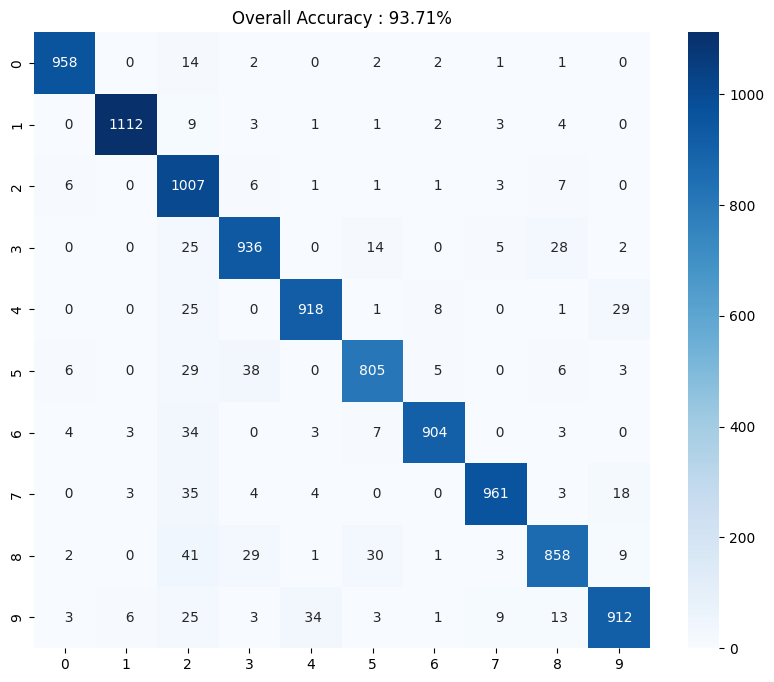

Classwise Accuracy Score: 

	0	1	2	3	4	5	6	7	8	9
	97.76	97.97	97.58	92.67	93.48	90.25	94.36	93.48	88.09	90.39

In [34]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import seaborn as sns

print('*** Classification Report ***')
print(classification_report(test_labels,pred_labels))
overallAccuracy = accuracy_score(test_labels,pred_labels)
cm = confusion_matrix(test_labels,pred_labels)
classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

plt.figure(figsize=(10, 8))
plt.title('Overall Accuracy : {0:3.2f}%'.format(overallAccuracy*100), size=12)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues',fmt='3.0f')

plt.show()

print('Classwise Accuracy Score: \n')

for i in range(10):
    print(f'\t{i}', end='')
print()
for acc in classwiseAccuracy:
    print(f'\t{acc*100:2.2f}', end='')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


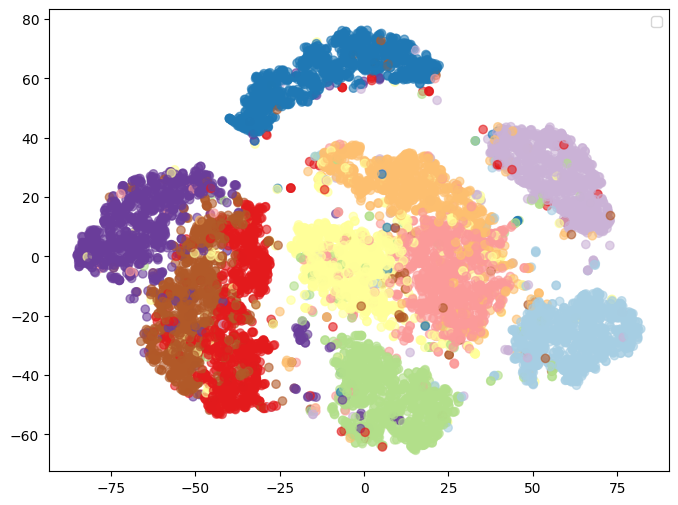

In [35]:
from sklearn.manifold import TSNE

plt.figure(figsize=(8, 6))
with torch.no_grad():
        X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=40).fit_transform(test_encoded)
        plt.scatter(X_embedded[:,0],X_embedded[:,1], c=test_labels,cmap="Paired", alpha = 0.6,marker='o')
plt.legend()
plt.show()

In [36]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox

## Function to Scale and visualize the embedding vectors
def plot_embedding(X,y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)     
    plt.figure(figsize=(12,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        ## only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 20e-3:
                ## don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(test_images[i].reshape(28,28), cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


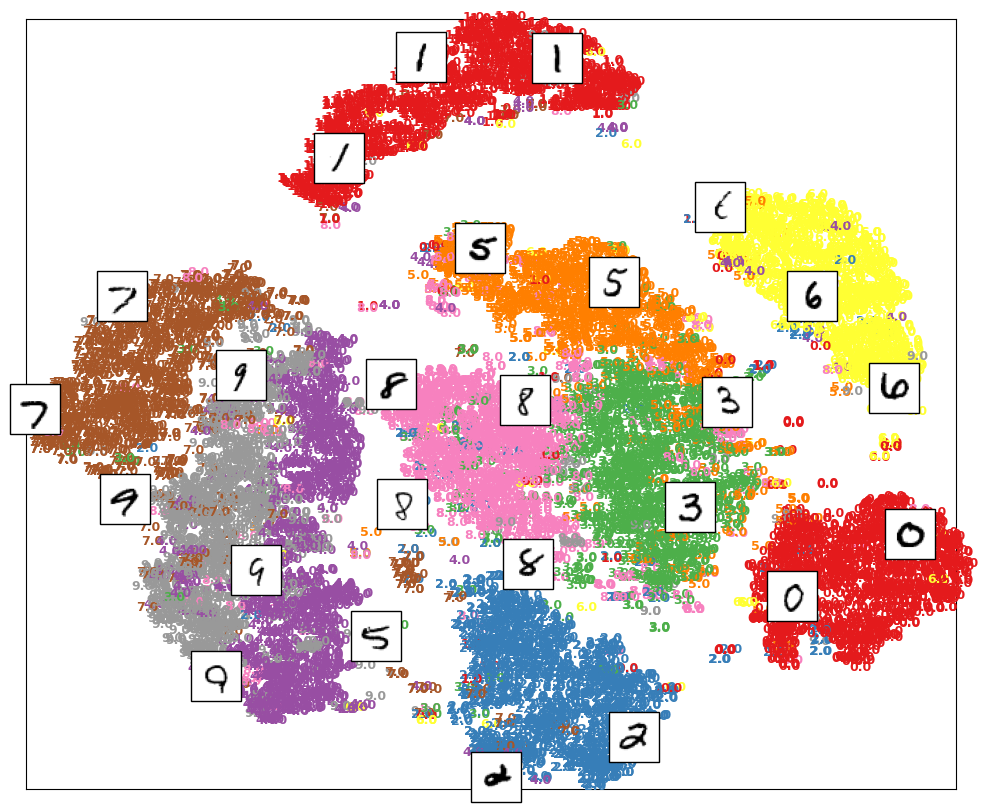

In [37]:
with torch.no_grad():
    plot_embedding(X_embedded,test_labels.numpy())